In [6]:
import pandas as pd

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_df['TP_encoded'] = encoder.fit_transform(train_df['team_playing'])
train_df['OP_encoded'] = encoder.fit_transform(train_df['opponent'])

In [8]:
test_df['TP_encoded'] = encoder.transform(test_df['team_playing'])
test_df['OP_encoded'] = encoder.transform(test_df['opponent'])

In [9]:
test_df.to_csv('data/test_encoded.csv', index = False)
train_df.to_csv('data/train_encoded.csv', index = False)


In [10]:
cols_to_drop = ['team_playing', 'opponent', 'target']
REGEX = 'TP_encoded|OP_encoded|is_home|FT_TP_G_rolling_mean|FT_OP_G_rolling_mean|target_rolling_mean'
#|OP_encoded|is_home|FT_TP_G_rolling_mean|HT_TP_G_rolling_mean|TP_S_rolling_mean|TP_ST_rolling_mean|TP_F_rolling_mean|TP_C_rolling_mean|TP_Y_rolling_mean|TP_R_rolling_mean|target_rolling_mean'
#'mean|Hour|std|sum|min|max'
X_train = train_df.filter(regex=REGEX)
y_train = train_df['target']

X_test = test_df.filter(regex=REGEX)
y_test = test_df['target']

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

models = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression()),
    'RandomForest': RandomForestClassifier(),
    'SVC': make_pipeline(StandardScaler(), SVC(probability=True)),
    'Gradient Boosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}	

results_df = pd.DataFrame(columns=['Accuracy', 'F1', 'Precision', 'Recall', 'Specificity'], index=models.keys())

predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    predictions[name] = {'y_pred':y_pred, 'y_proba':y_proba}

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    spec = specificity(y_test, y_pred)

    

    results_df.loc[name] = [accuracy, f1, precision, recall, spec]

results_df = results_df.astype(float)
print(results_df.round(2))

                     Accuracy    F1  Precision  Recall  Specificity
XGBoost                  0.68  0.68       0.68    0.68         0.75
Logistic Regression      0.70  0.66       0.70    0.70         0.94
RandomForest             0.68  0.66       0.66    0.68         0.84
SVC                      0.66  0.62       0.64    0.66         0.88
Gradient Boosting        0.70  0.68       0.69    0.70         0.88
CatBoost                 0.70  0.69       0.69    0.70         0.84


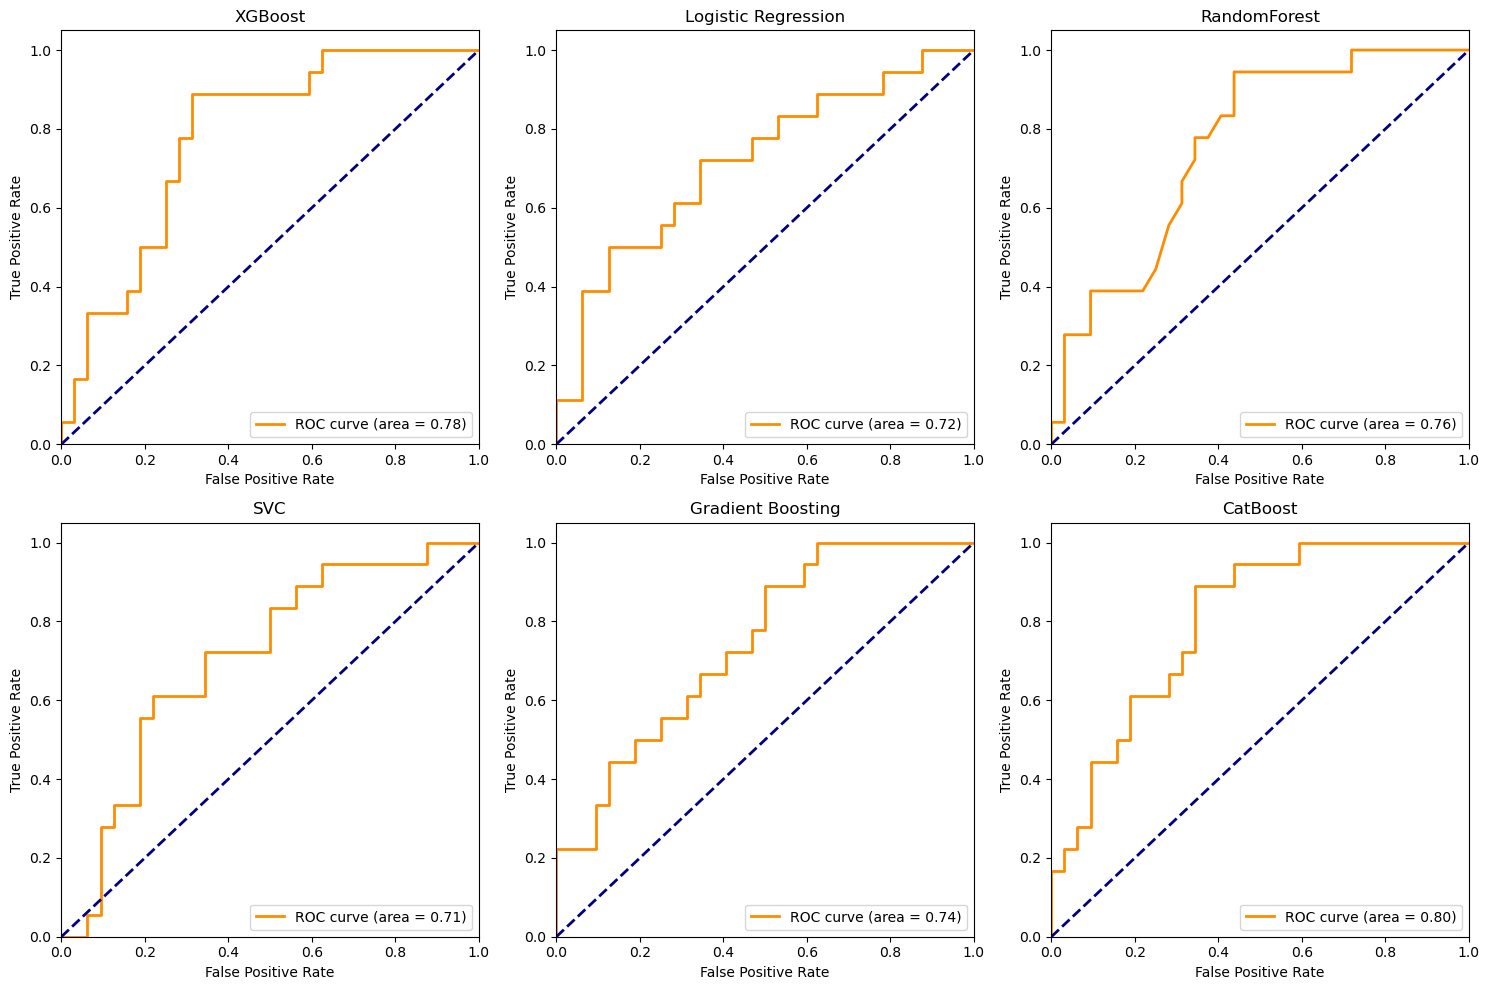

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=.5, wspace=.5)
axs = axs.ravel()

for i, (name, prediction) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, prediction['y_proba'][:, 1])
    roc_auc = auc(fpr, tpr)
    
    axs[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(f'{name}')
    axs[i].legend(loc="lower right")

plt.tight_layout()
plt.show()
